### Libraries

In [1]:
import contextily as cx
from ipywidgets import interact
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from pyrsgis import raster
from pyrsgis.convert import array_to_table
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential

### Loading the multispectral image

In [2]:
# file names
feature_file = './BrokenHill_Landsat9.tif'

# read the image
dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
arrFeatures = arrFeatures.astype(float)

min_x = dsFeatures.bbox[0][0]
max_x = dsFeatures.bbox[1][0]
min_y = dsFeatures.bbox[0][1]
max_y = dsFeatures.bbox[1][1]

extent = [min_x, max_x, min_y, max_y]

### Visualizing spectral bands

In [3]:
def plot_array_stretched(array, label, n):
    fig, ax = plt.subplots(figsize=(10, 10))
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent, vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

@interact(band=range(1, arrFeatures.shape[0]+1))
def show_dist(band):
    plot_array_stretched(arrFeatures[band-1, :, :], f'Band {band}', 3)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7), value=1), Output()), _dom_cl…

### Normalizing

In [4]:
arrFeatures = array_to_table(arrFeatures)
arrFeatures_fuzzy = np.zeros(arrFeatures.shape)

# normalize the image
for i in range(arrFeatures.shape[1]):
    bandMin = arrFeatures[:, i].min()
    bandMax = arrFeatures[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[0]):
        arrFeatures_fuzzy[j, i] = (arrFeatures[j, i]-bandMin)/bandRange

### Loading the training dataset (manual)

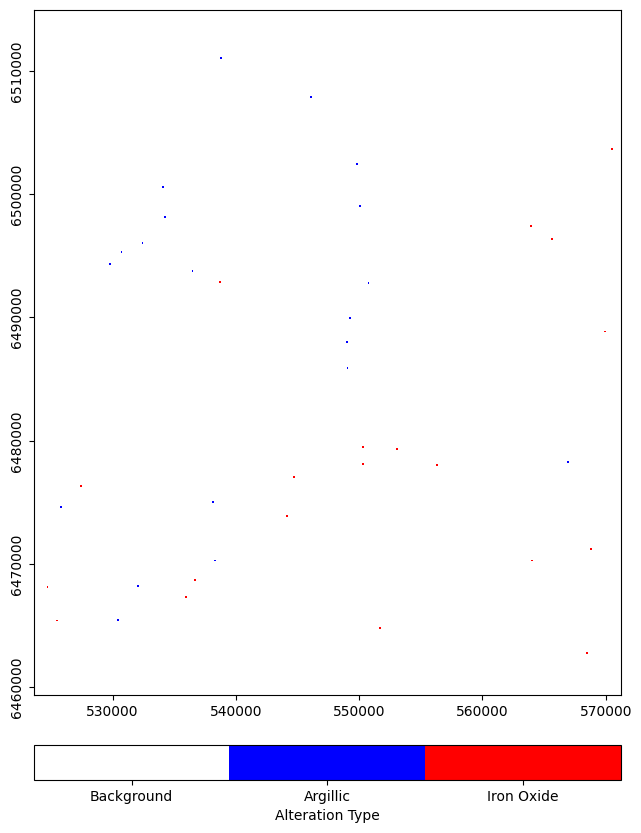

In [5]:
positiveLabel_file = './BrokenHill_Landsat8_Manual_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'red'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent, interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [6]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = arrFeatures_fuzzy[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = arrFeatures_fuzzy[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0
# call the function to split the dataset
train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.7)

### Training the model using MLP

Epoch 1/100
33/33 [==============================] - 0s 5ms/step - loss: 1.1058 - accuracy: 0.3848 - val_loss: 1.0688 - val_accuracy: 0.4156
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 1.0348 - accuracy: 0.5000 - val_loss: 1.0325 - val_accuracy: 0.5178
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9842 - accuracy: 0.5562 - val_loss: 0.9464 - val_accuracy: 0.6378
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9028 - accuracy: 0.6057 - val_loss: 0.9055 - val_accuracy: 0.5178
Epoch 5/100
33/33 [==============================] - 0s 2ms/step - loss: 0.8532 - accuracy: 0.6314 - val_loss: 0.8410 - val_accuracy: 0.5956
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 0.8009 - accuracy: 0.6419 - val_loss: 0.7908 - val_accuracy: 0.7067
Epoch 7/100
33/33 [==============================] - 0s 2ms/step - loss: 0.7653 - accuracy: 0.6724 - val_loss: 0.7650 - val_accuracy: 0.7067
Epoch 8/100
3

Epoch 59/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2604 - accuracy: 0.9038 - val_loss: 0.2770 - val_accuracy: 0.8978
Epoch 60/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2570 - accuracy: 0.9114 - val_loss: 0.2843 - val_accuracy: 0.8867
Epoch 61/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2577 - accuracy: 0.9019 - val_loss: 0.3180 - val_accuracy: 0.8911
Epoch 62/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2570 - accuracy: 0.9105 - val_loss: 0.2793 - val_accuracy: 0.8933
Epoch 63/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2536 - accuracy: 0.9038 - val_loss: 0.2784 - val_accuracy: 0.8867
Epoch 64/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.8952 - val_loss: 0.2798 - val_accuracy: 0.9000
Epoch 65/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2724 - accuracy: 0.9019 - val_loss: 0.3371 - val_accuracy: 0.8667
Epoch 

33/33 [==============================] - 0s 2ms/step - loss: 0.7186 - accuracy: 0.7162 - val_loss: 0.7425 - val_accuracy: 0.5889
Epoch 10/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.7324 - val_loss: 0.7245 - val_accuracy: 0.7489
Epoch 11/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6842 - accuracy: 0.7600 - val_loss: 0.7007 - val_accuracy: 0.7889
Epoch 12/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6617 - accuracy: 0.7886 - val_loss: 0.6798 - val_accuracy: 0.7667
Epoch 13/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6523 - accuracy: 0.7781 - val_loss: 0.6789 - val_accuracy: 0.7133
Epoch 14/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6324 - accuracy: 0.7876 - val_loss: 0.6558 - val_accuracy: 0.8089
Epoch 15/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6083 - accuracy: 0.8114 - val_loss: 0.6245 - val_accuracy: 0.8356
Epoch 16/100
33/33 

Epoch 67/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2303 - accuracy: 0.9114 - val_loss: 0.2599 - val_accuracy: 0.9267
Epoch 68/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2296 - accuracy: 0.9133 - val_loss: 0.2492 - val_accuracy: 0.9156
Epoch 69/100
33/33 [==============================] - 0s 1ms/step - loss: 0.2321 - accuracy: 0.9200 - val_loss: 0.2833 - val_accuracy: 0.9089
Epoch 70/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2672 - accuracy: 0.8971 - val_loss: 0.3102 - val_accuracy: 0.8978
Epoch 71/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2362 - accuracy: 0.9124 - val_loss: 0.2590 - val_accuracy: 0.9289
Epoch 72/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2310 - accuracy: 0.9133 - val_loss: 0.2542 - val_accuracy: 0.9111
Epoch 73/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2326 - accuracy: 0.9152 - val_loss: 0.2503 - val_accuracy: 0.9222
Epoch 

33/33 [==============================] - 0s 2ms/step - loss: 0.5454 - accuracy: 0.8371 - val_loss: 0.5210 - val_accuracy: 0.8311
Epoch 18/100
33/33 [==============================] - 0s 2ms/step - loss: 0.5183 - accuracy: 0.8419 - val_loss: 0.4817 - val_accuracy: 0.8489
Epoch 19/100
33/33 [==============================] - 0s 2ms/step - loss: 0.5141 - accuracy: 0.8295 - val_loss: 0.4686 - val_accuracy: 0.8556
Epoch 20/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4850 - accuracy: 0.8552 - val_loss: 0.4529 - val_accuracy: 0.8422
Epoch 21/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4666 - accuracy: 0.8543 - val_loss: 0.4308 - val_accuracy: 0.8600
Epoch 22/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4505 - accuracy: 0.8619 - val_loss: 0.4195 - val_accuracy: 0.8600
Epoch 23/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4362 - accuracy: 0.8610 - val_loss: 0.3951 - val_accuracy: 0.8600
Epoch 24/100
33/33 

Epoch 75/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2374 - accuracy: 0.9086 - val_loss: 0.2269 - val_accuracy: 0.9222
Epoch 76/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2513 - accuracy: 0.9057 - val_loss: 0.2430 - val_accuracy: 0.9089
Epoch 77/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2381 - accuracy: 0.9114 - val_loss: 0.2178 - val_accuracy: 0.9267
Epoch 78/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2582 - accuracy: 0.9076 - val_loss: 0.2616 - val_accuracy: 0.9111
Epoch 79/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2469 - accuracy: 0.9133 - val_loss: 0.2055 - val_accuracy: 0.9222
Epoch 80/100
33/33 [==============================] - 0s 1ms/step - loss: 0.2466 - accuracy: 0.9067 - val_loss: 0.2152 - val_accuracy: 0.9089
Epoch 81/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2351 - accuracy: 0.9162 - val_loss: 0.2023 - val_accuracy: 0.9244
Epoch 

33/33 [==============================] - 0s 2ms/step - loss: 0.4661 - accuracy: 0.8533 - val_loss: 0.4760 - val_accuracy: 0.8422
Epoch 26/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4526 - accuracy: 0.8600 - val_loss: 0.4507 - val_accuracy: 0.8644
Epoch 27/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.8629 - val_loss: 0.4826 - val_accuracy: 0.8156
Epoch 28/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4189 - accuracy: 0.8724 - val_loss: 0.4213 - val_accuracy: 0.8578
Epoch 29/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4020 - accuracy: 0.8771 - val_loss: 0.4355 - val_accuracy: 0.8511
Epoch 30/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4081 - accuracy: 0.8695 - val_loss: 0.4234 - val_accuracy: 0.8667
Epoch 31/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3839 - accuracy: 0.8733 - val_loss: 0.4035 - val_accuracy: 0.8756
Epoch 32/100
33/33 

Epoch 83/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2395 - accuracy: 0.9086 - val_loss: 0.2455 - val_accuracy: 0.9089
Epoch 84/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2426 - accuracy: 0.9076 - val_loss: 0.2489 - val_accuracy: 0.9200
Epoch 85/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2313 - accuracy: 0.9114 - val_loss: 0.2500 - val_accuracy: 0.9044
Epoch 86/100
33/33 [==============================] - 0s 1ms/step - loss: 0.2332 - accuracy: 0.9048 - val_loss: 0.2382 - val_accuracy: 0.9289
Epoch 87/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2294 - accuracy: 0.9105 - val_loss: 0.2465 - val_accuracy: 0.9178
Epoch 88/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2414 - accuracy: 0.9086 - val_loss: 0.2344 - val_accuracy: 0.9244
Epoch 89/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2359 - accuracy: 0.9095 - val_loss: 0.2275 - val_accuracy: 0.9378
Epoch 

33/33 [==============================] - 0s 1ms/step - loss: 0.3132 - accuracy: 0.8952 - val_loss: 0.3525 - val_accuracy: 0.8667
Epoch 34/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3191 - accuracy: 0.8971 - val_loss: 0.2961 - val_accuracy: 0.9067
Epoch 35/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3109 - accuracy: 0.9010 - val_loss: 0.2793 - val_accuracy: 0.9067
Epoch 36/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3024 - accuracy: 0.8971 - val_loss: 0.2776 - val_accuracy: 0.9200
Epoch 37/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2897 - accuracy: 0.9038 - val_loss: 0.2749 - val_accuracy: 0.9000
Epoch 38/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2941 - accuracy: 0.9029 - val_loss: 0.3262 - val_accuracy: 0.8778
Epoch 39/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2887 - accuracy: 0.8933 - val_loss: 0.2674 - val_accuracy: 0.9133
Epoch 40/100
33/33 

Epoch 91/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2127 - accuracy: 0.9238 - val_loss: 0.1972 - val_accuracy: 0.9311
Epoch 92/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2394 - accuracy: 0.9143 - val_loss: 0.2047 - val_accuracy: 0.9244
Epoch 93/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.9238 - val_loss: 0.2101 - val_accuracy: 0.9267
Epoch 94/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2109 - accuracy: 0.9248 - val_loss: 0.2342 - val_accuracy: 0.9156
Epoch 95/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2178 - accuracy: 0.9152 - val_loss: 0.2373 - val_accuracy: 0.9222
Epoch 96/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2123 - accuracy: 0.9267 - val_loss: 0.2189 - val_accuracy: 0.9222
Epoch 97/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.9257 - val_loss: 0.2040 - val_accuracy: 0.9333
Epoch 

33/33 [==============================] - 0s 2ms/step - loss: 0.3384 - accuracy: 0.8800 - val_loss: 0.3730 - val_accuracy: 0.8711
Epoch 42/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3781 - accuracy: 0.8638 - val_loss: 0.3036 - val_accuracy: 0.8956
Epoch 43/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3368 - accuracy: 0.8819 - val_loss: 0.3568 - val_accuracy: 0.8778
Epoch 44/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3255 - accuracy: 0.8838 - val_loss: 0.2998 - val_accuracy: 0.9000
Epoch 45/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3145 - accuracy: 0.8895 - val_loss: 0.2897 - val_accuracy: 0.9044
Epoch 46/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3206 - accuracy: 0.8810 - val_loss: 0.3445 - val_accuracy: 0.8800
Epoch 47/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3196 - accuracy: 0.8781 - val_loss: 0.2848 - val_accuracy: 0.9000
Epoch 48/100
33/33 

Epoch 99/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2207 - accuracy: 0.9248 - val_loss: 0.2264 - val_accuracy: 0.9156
Epoch 100/100
15/15 [==============================] - 0s 786us/step
Epoch 1/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0944 - accuracy: 0.4229 - val_loss: 1.0751 - val_accuracy: 0.5733
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 1.0612 - accuracy: 0.4400 - val_loss: 1.0543 - val_accuracy: 0.4156
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 1.0255 - accuracy: 0.4781 - val_loss: 0.9911 - val_accuracy: 0.5444
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9436 - accuracy: 0.7457 - val_loss: 0.9020 - val_accuracy: 0.6867
Epoch 5/100
33/33 [==============================] - 0s 2ms/step - loss: 0.8621 - accuracy: 0.6524 - val_loss: 0.8310 - val_accuracy: 0.7067
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 0.7933 - ac

33/33 [==============================] - 0s 2ms/step - loss: 0.2805 - accuracy: 0.9000 - val_loss: 0.3185 - val_accuracy: 0.8978
Epoch 50/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2745 - accuracy: 0.8990 - val_loss: 0.2889 - val_accuracy: 0.8978
Epoch 51/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2704 - accuracy: 0.9038 - val_loss: 0.3038 - val_accuracy: 0.8822
Epoch 52/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2821 - accuracy: 0.8952 - val_loss: 0.2848 - val_accuracy: 0.9067
Epoch 53/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2718 - accuracy: 0.9038 - val_loss: 0.2915 - val_accuracy: 0.8889
Epoch 54/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2621 - accuracy: 0.9010 - val_loss: 0.2898 - val_accuracy: 0.9022
Epoch 55/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2570 - accuracy: 0.9048 - val_loss: 0.2903 - val_accuracy: 0.8933
Epoch 56/100
33/33 

15/15 [==============================] - 0s 762us/step
Epoch 1/100
33/33 [==============================] - 0s 4ms/step - loss: 1.1347 - accuracy: 0.3524 - val_loss: 1.0755 - val_accuracy: 0.3444
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 1.0688 - accuracy: 0.4829 - val_loss: 1.0594 - val_accuracy: 0.5422
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 1.0419 - accuracy: 0.5714 - val_loss: 1.0313 - val_accuracy: 0.4400
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9945 - accuracy: 0.5648 - val_loss: 0.9564 - val_accuracy: 0.5778
Epoch 5/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9188 - accuracy: 0.6581 - val_loss: 0.8875 - val_accuracy: 0.5844
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 0.8503 - accuracy: 0.6267 - val_loss: 0.8044 - val_accuracy: 0.6244
Epoch 7/100
33/33 [==============================] - 0s 2ms/step - loss: 0.7830 - accuracy: 0.6752 

Epoch 57/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2680 - accuracy: 0.9019 - val_loss: 0.2569 - val_accuracy: 0.9156
Epoch 58/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2696 - accuracy: 0.9010 - val_loss: 0.3176 - val_accuracy: 0.8756
Epoch 59/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2538 - accuracy: 0.9143 - val_loss: 0.2615 - val_accuracy: 0.9133
Epoch 60/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2510 - accuracy: 0.9038 - val_loss: 0.2414 - val_accuracy: 0.9178
Epoch 61/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2628 - accuracy: 0.9076 - val_loss: 0.2830 - val_accuracy: 0.8933
Epoch 62/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2490 - accuracy: 0.9124 - val_loss: 0.2756 - val_accuracy: 0.8933
Epoch 63/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2427 - accuracy: 0.9076 - val_loss: 0.2400 - val_accuracy: 0.9178
Epoch 

Epoch 7/100
33/33 [==============================] - 0s 2ms/step - loss: 0.7662 - accuracy: 0.6562 - val_loss: 0.7321 - val_accuracy: 0.6689
Epoch 8/100
33/33 [==============================] - 0s 2ms/step - loss: 0.7280 - accuracy: 0.6800 - val_loss: 0.7389 - val_accuracy: 0.5867
Epoch 9/100
33/33 [==============================] - 0s 2ms/step - loss: 0.7174 - accuracy: 0.7190 - val_loss: 0.7007 - val_accuracy: 0.7778
Epoch 10/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6861 - accuracy: 0.7524 - val_loss: 0.6739 - val_accuracy: 0.7800
Epoch 11/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6828 - accuracy: 0.7248 - val_loss: 0.6709 - val_accuracy: 0.6733
Epoch 12/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6509 - accuracy: 0.7610 - val_loss: 0.6349 - val_accuracy: 0.8178
Epoch 13/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6386 - accuracy: 0.7695 - val_loss: 0.6154 - val_accuracy: 0.8067
Epoch 14/

Epoch 65/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2583 - accuracy: 0.9086 - val_loss: 0.2846 - val_accuracy: 0.8822
Epoch 66/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.9067 - val_loss: 0.2516 - val_accuracy: 0.9133
Epoch 67/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2577 - accuracy: 0.9057 - val_loss: 0.2684 - val_accuracy: 0.8956
Epoch 68/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2576 - accuracy: 0.9162 - val_loss: 0.2345 - val_accuracy: 0.9200
Epoch 69/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2469 - accuracy: 0.9124 - val_loss: 0.2605 - val_accuracy: 0.8911
Epoch 70/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2586 - accuracy: 0.9067 - val_loss: 0.2387 - val_accuracy: 0.9178
Epoch 71/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.9124 - val_loss: 0.2780 - val_accuracy: 0.9111
Epoch 

33/33 [==============================] - 0s 2ms/step - loss: 0.6259 - accuracy: 0.7829 - val_loss: 0.6381 - val_accuracy: 0.7733
Epoch 16/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6411 - accuracy: 0.7295 - val_loss: 0.6001 - val_accuracy: 0.7533
Epoch 17/100
33/33 [==============================] - 0s 2ms/step - loss: 0.5922 - accuracy: 0.8171 - val_loss: 0.5571 - val_accuracy: 0.8422
Epoch 18/100
33/33 [==============================] - 0s 2ms/step - loss: 0.5702 - accuracy: 0.8133 - val_loss: 0.5406 - val_accuracy: 0.8378
Epoch 19/100
33/33 [==============================] - 0s 1ms/step - loss: 0.5530 - accuracy: 0.8152 - val_loss: 0.5260 - val_accuracy: 0.8578
Epoch 20/100
33/33 [==============================] - 0s 2ms/step - loss: 0.5375 - accuracy: 0.8324 - val_loss: 0.5037 - val_accuracy: 0.8533
Epoch 21/100
33/33 [==============================] - 0s 2ms/step - loss: 0.5159 - accuracy: 0.8400 - val_loss: 0.4869 - val_accuracy: 0.8622
Epoch 22/100
33/33 

Epoch 73/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.9029 - val_loss: 0.2334 - val_accuracy: 0.9133
Epoch 74/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2541 - accuracy: 0.8990 - val_loss: 0.2344 - val_accuracy: 0.9200
Epoch 75/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2558 - accuracy: 0.9048 - val_loss: 0.2429 - val_accuracy: 0.9178
Epoch 76/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2545 - accuracy: 0.9086 - val_loss: 0.2373 - val_accuracy: 0.9156
Epoch 77/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2427 - accuracy: 0.9114 - val_loss: 0.2410 - val_accuracy: 0.9133
Epoch 78/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2504 - accuracy: 0.9114 - val_loss: 0.2269 - val_accuracy: 0.9222
Epoch 79/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2511 - accuracy: 0.9067 - val_loss: 0.2236 - val_accuracy: 0.9200
Epoch 

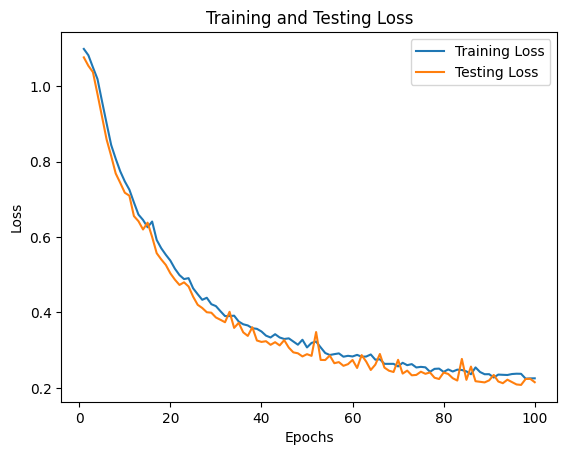

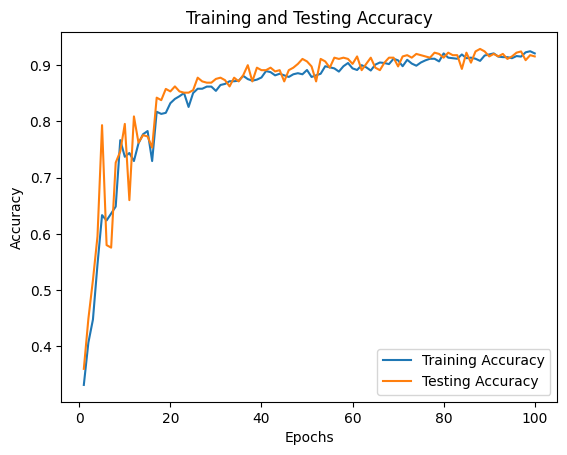

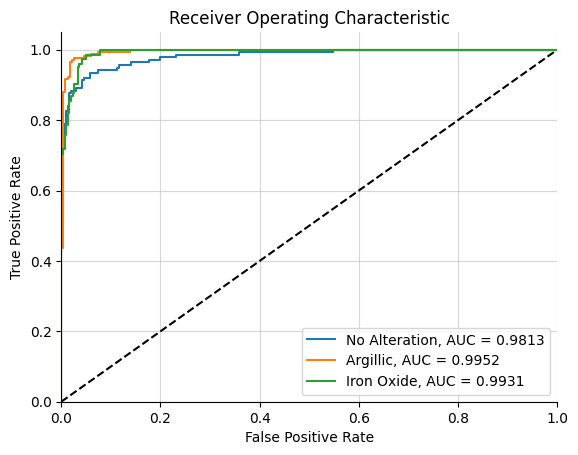

ROC AUC score: 0.9898380481695089


In [7]:
def roc_auc(model, test_x, test_y, n_classes):
    roc_auc = []
    test_z = model.predict(test_x)
    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        roc_auc.append(roc_auc_score(test_y_dummies[:, i], test_z[:, i]))
    
    return roc_auc

# plot any graph relating to any model
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and Testing '+metric.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend(['Training '+metric.capitalize(), 'Testing '+metric.capitalize()])
    plt.show()
    
def roc_plot(test_y, test_z, n_classes, labels_name, average='macro'):
    fpr = {}
    tpr = {}
    roc_auc = {}

    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_dummies[:, i], test_z[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='{}, AUC = {}'.format(labels_name[i], '{0:.4f}'.format(roc_auc[i])))
    
    ax.legend(loc='best')
    ax.grid(alpha=0.5)
    sns.despine()
    plt.show()
    print('ROC AUC score:', roc_auc_score(test_y_dummies, test_z, average=average))

best_model = tf.keras.models.Sequential()
best_accuracy = 0
best_history = None
experimental_runs = 10
cv = 10
metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_No Alteration', 'AUC_Argillic', 'AUC_Iron Oxide', 'AUC_Aggregate']
temp_metrics_df = pd.DataFrame(np.zeros((cv, len(metrics_columns))), columns=metrics_columns)

for i in range(experimental_runs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(5, activation='selu', input_shape=(train_x.shape[1], )))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=100, validation_data=(test_x, test_y))
    
    for j in range(cv):
        train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.7)
        # predict for the test dataset
        test_z = model.predict(test_x)
        # calculate and display error metrics
        test_z_class = test_z.argmax(axis=1)
        
        aScore = accuracy_score(test_y, test_z_class)
        pScore = precision_score(test_y, test_z_class, average='macro')
        rScore = recall_score(test_y, test_z_class, average='macro')
        fScore = f1_score(test_y, test_z_class, average='macro')
        cMatrix = confusion_matrix(test_y, test_z_class)
        metrics_array = [aScore, pScore, rScore, fScore]
        roc_auc_class = roc_auc(model, test_x, test_y, n_class_pos)

        for k in range(n_class_pos):
            metrics_array.append(roc_auc_class[k])

        roc_auc_mean = mean(roc_auc_class)
        metrics_array.append(roc_auc_mean)
        temp_metrics_df.loc[j] = metrics_array
        
        if j==cv-1:
            # accuracy can be replaced with other scores
            aScore_avg = temp_metrics_df['Accuracy'].mean()
            
            if best_accuracy < aScore_avg:
                best_model = model
                best_accuracy_avg = aScore_avg
                best_history = history

print(f'\nBest Average Accuracy:\n{best_accuracy_avg}')

test_z = best_model.predict(test_x)
test_z_class = test_z.argmax(axis=1)
aScore = accuracy_score(test_y, test_z_class)
pScore = precision_score(test_y, test_z_class, average='macro')
rScore = recall_score(test_y, test_z_class, average='macro')
fScore = f1_score(test_y, test_z_class, average='macro')
cMatrix = confusion_matrix(test_y, test_z_class)
metrics_array = [aScore, pScore, rScore, fScore]
roc_auc_class = roc_auc(best_model, test_x, test_y, n_class_pos)
metrics_array.extend(roc_auc_class)
roc_auc_mean = mean(roc_auc_class)
metrics_array.append(roc_auc_mean)

print(f'\nConfusion Matrix:\n{cMatrix}')
print(f'\nAccuracy: {aScore}')
print(f'\nPrecision: {pScore}')
print(f'\nRecall: {rScore}')
print(f'\nF1 Score: {fScore}')

plot_metric(history, 'loss')
print('')
plot_metric(history, 'accuracy')
labels_name = ['No Alteration', 'Argillic', 'Iron Oxide']
roc_plot(test_y, test_z, n_class_pos, labels_name)

### Mapping alteration zones

91947/91947 [==============================] - 50s 544us/step


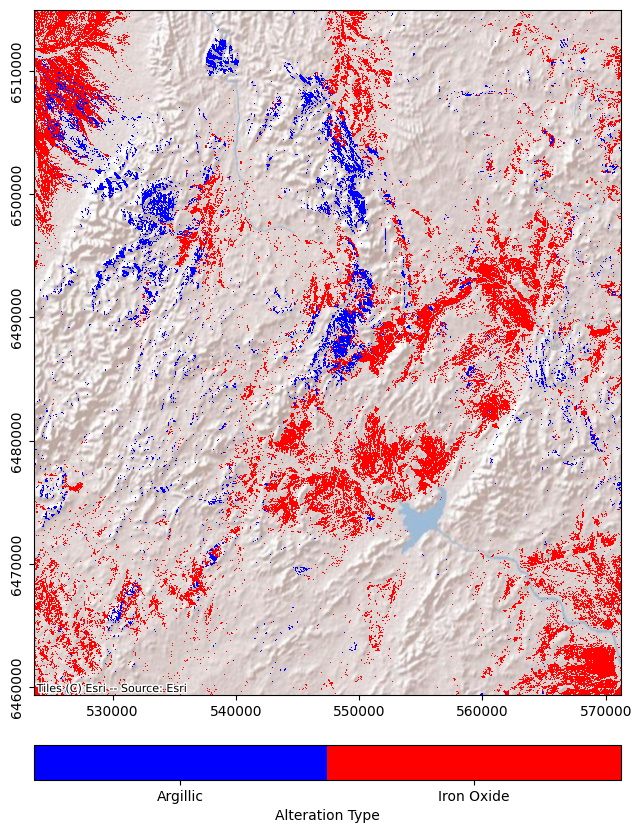

In [8]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_Landsat9.tif')
arrPred = arrPred.astype(float)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = best_model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

outFile = './Outputs/BrokenHill_Landsat9_Manual_MLP_AlterationMap.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Loading the training dataset (PCA)

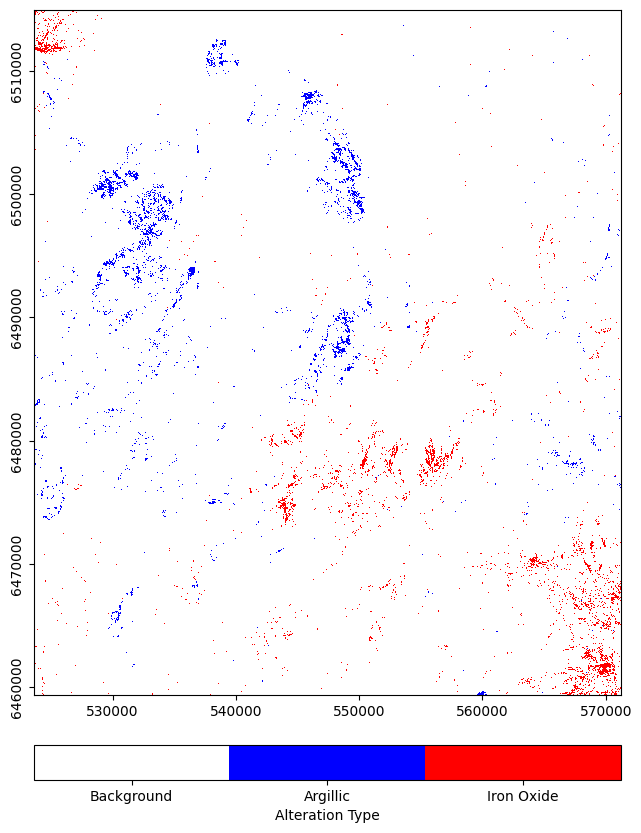

In [9]:
positiveLabel_file = './BrokenHill_Landsat9_PCA_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'red'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent, interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [10]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = arrFeatures_fuzzy[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = arrFeatures_fuzzy[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0
# call the function to split the dataset
train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.7)

### Training the model using MLP

Epoch 1/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.5532 - accuracy: 0.7983 - val_loss: 0.2602 - val_accuracy: 0.9314
Epoch 2/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.2022 - accuracy: 0.9405 - val_loss: 0.1409 - val_accuracy: 0.9640
Epoch 3/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1373 - accuracy: 0.9590 - val_loss: 0.1088 - val_accuracy: 0.9682
Epoch 4/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1052 - accuracy: 0.9711 - val_loss: 0.1033 - val_accuracy: 0.9714
Epoch 5/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0903 - accuracy: 0.9756 - val_loss: 0.0902 - val_accuracy: 0.9704
Epoch 6/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0820 - accuracy: 0.9786 - val_loss: 0.0701 - val_accuracy: 0.9825
Epoch 7/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0813 - accuracy: 0.9791 - val_loss: 0.0649 - val_accuracy:

764/764 [==============================] - 0s 611us/step
Epoch 1/50
1781/1781 [==============================] - 3s 1ms/step - loss: 0.5005 - accuracy: 0.8190 - val_loss: 0.2464 - val_accuracy: 0.9219
Epoch 2/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1853 - accuracy: 0.9439 - val_loss: 0.1423 - val_accuracy: 0.9537
Epoch 3/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1265 - accuracy: 0.9628 - val_loss: 0.1049 - val_accuracy: 0.9667
Epoch 4/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1024 - accuracy: 0.9712 - val_loss: 0.0959 - val_accuracy: 0.9687
Epoch 5/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0923 - accuracy: 0.9751 - val_loss: 0.0684 - val_accuracy: 0.9835
Epoch 6/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0842 - accuracy: 0.9782 - val_loss: 0.0660 - val_accuracy: 0.9826
Epoch 7/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0

764/764 [==============================] - 1s 771us/step
Epoch 1/50
1781/1781 [==============================] - 3s 1ms/step - loss: 0.5469 - accuracy: 0.8085 - val_loss: 0.2521 - val_accuracy: 0.9308
Epoch 2/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1887 - accuracy: 0.9438 - val_loss: 0.1644 - val_accuracy: 0.9376
Epoch 3/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1179 - accuracy: 0.9664 - val_loss: 0.0948 - val_accuracy: 0.9686
Epoch 4/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0963 - accuracy: 0.9737 - val_loss: 0.0722 - val_accuracy: 0.9830
Epoch 5/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0878 - accuracy: 0.9763 - val_loss: 0.0996 - val_accuracy: 0.9697
Epoch 6/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0793 - accuracy: 0.9786 - val_loss: 0.1316 - val_accuracy: 0.9606
Epoch 7/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0

Epoch 50/50
764/764 [==============================] - 0s 613us/step
Epoch 1/50
1781/1781 [==============================] - 3s 1ms/step - loss: 0.5275 - accuracy: 0.8104 - val_loss: 0.2592 - val_accuracy: 0.9278
Epoch 2/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1970 - accuracy: 0.9414 - val_loss: 0.1348 - val_accuracy: 0.9660
Epoch 3/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1282 - accuracy: 0.9634 - val_loss: 0.1607 - val_accuracy: 0.9499
Epoch 4/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1032 - accuracy: 0.9713 - val_loss: 0.0966 - val_accuracy: 0.9717
Epoch 5/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0916 - accuracy: 0.9758 - val_loss: 0.0777 - val_accuracy: 0.9782
Epoch 6/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0851 - accuracy: 0.9772 - val_loss: 0.0791 - val_accuracy: 0.9858
Epoch 7/50
1781/1781 [==============================] - 2s 1ms/step

Epoch 49/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0504 - accuracy: 0.9860 - val_loss: 0.0499 - val_accuracy: 0.9885
Epoch 50/50
764/764 [==============================] - 1s 665us/step
Epoch 1/50
1781/1781 [==============================] - 3s 2ms/step - loss: 0.5018 - accuracy: 0.8266 - val_loss: 0.2627 - val_accuracy: 0.9115
Epoch 2/50
1781/1781 [==============================] - 3s 1ms/step - loss: 0.2030 - accuracy: 0.9342 - val_loss: 0.1805 - val_accuracy: 0.9395
Epoch 3/50
1781/1781 [==============================] - 3s 2ms/step - loss: 0.1304 - accuracy: 0.9603 - val_loss: 0.1074 - val_accuracy: 0.9757
Epoch 4/50
1781/1781 [==============================] - 3s 1ms/step - loss: 0.1032 - accuracy: 0.9698 - val_loss: 0.0942 - val_accuracy: 0.9787
Epoch 5/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0872 - accuracy: 0.9759 - val_loss: 0.0681 - val_accuracy: 0.9840
Epoch 6/50
1781/1781 [==============================] - 2s 1ms/ste

Epoch 48/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0601 - accuracy: 0.9853 - val_loss: 0.0777 - val_accuracy: 0.9814
Epoch 49/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0608 - accuracy: 0.9851 - val_loss: 0.0573 - val_accuracy: 0.9857
Epoch 50/50
764/764 [==============================] - 1s 643us/step
Epoch 1/50
1781/1781 [==============================] - 3s 1ms/step - loss: 0.5425 - accuracy: 0.8018 - val_loss: 0.2671 - val_accuracy: 0.9215
Epoch 2/50
1781/1781 [==============================] - 3s 1ms/step - loss: 0.1968 - accuracy: 0.9403 - val_loss: 0.1452 - val_accuracy: 0.9539
Epoch 3/50
1781/1781 [==============================] - 3s 2ms/step - loss: 0.1305 - accuracy: 0.9614 - val_loss: 0.1005 - val_accuracy: 0.9733
Epoch 4/50
1781/1781 [==============================] - 3s 1ms/step - loss: 0.1037 - accuracy: 0.9707 - val_loss: 0.0866 - val_accuracy: 0.9719
Epoch 5/50
1781/1781 [==============================] - 3s 1ms/st

Epoch 47/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0616 - accuracy: 0.9849 - val_loss: 0.0482 - val_accuracy: 0.9884
Epoch 48/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0585 - accuracy: 0.9855 - val_loss: 0.0411 - val_accuracy: 0.9928
Epoch 49/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0588 - accuracy: 0.9860 - val_loss: 0.0927 - val_accuracy: 0.9731
Epoch 50/50
764/764 [==============================] - 1s 674us/step
Epoch 1/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.5546 - accuracy: 0.7994 - val_loss: 0.2587 - val_accuracy: 0.9223
Epoch 2/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1878 - accuracy: 0.9489 - val_loss: 0.1392 - val_accuracy: 0.9588
Epoch 3/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.1233 - accuracy: 0.9652 - val_loss: 0.1396 - val_accuracy: 0.9515
Epoch 4/50
1781/1781 [==============================] - 2s 1ms/s

Epoch 46/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0604 - accuracy: 0.9857 - val_loss: 0.0703 - val_accuracy: 0.9790
Epoch 47/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0608 - accuracy: 0.9850 - val_loss: 0.0447 - val_accuracy: 0.9873
Epoch 48/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0606 - accuracy: 0.9856 - val_loss: 0.0475 - val_accuracy: 0.9915
Epoch 49/50
1781/1781 [==============================] - 2s 1ms/step - loss: 0.0598 - accuracy: 0.9857 - val_loss: 0.0490 - val_accuracy: 0.9943
Epoch 50/50
764/764 [==============================] - 0s 561us/step

Best Average Accuracy:
0.9886759225130032
764/764 [==============================] - 0s 552us/step

Confusion Matrix:
[[8048   92   59]
 [   0 8153    0]
 [ 134    2 7929]]

Accuracy: 0.9882458942540033

Precision: 0.9882794742980869

Recall: 0.9882400438906543

F1 Score: 0.9882409417503898


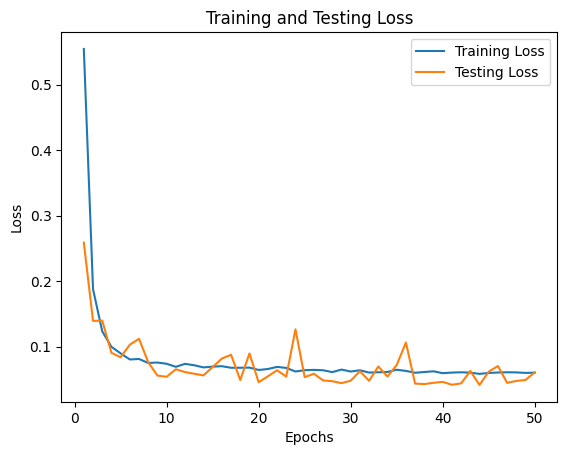

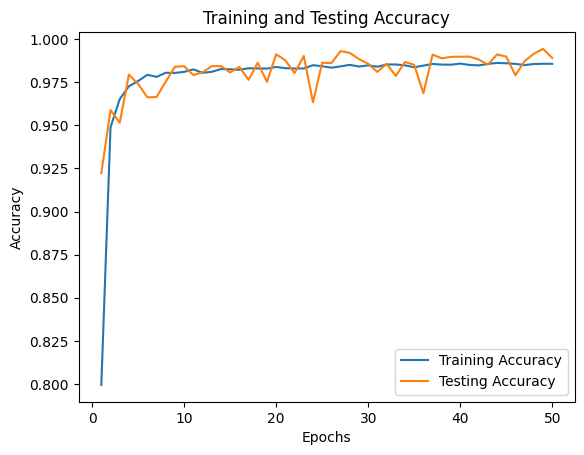

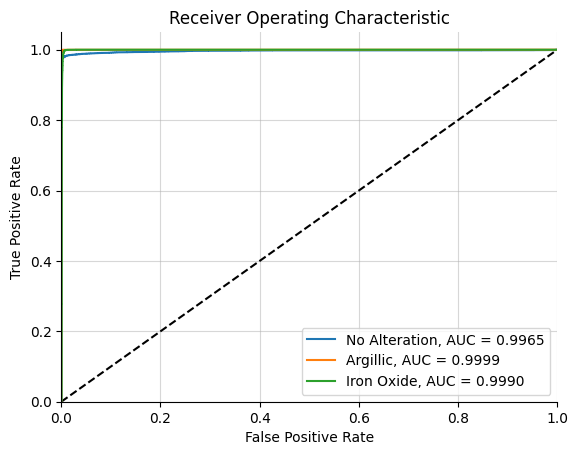

ROC AUC score: 0.9984452816425033


In [11]:
best_model = tf.keras.models.Sequential()
best_accuracy = 0
best_history = None
experimental_runs = 10
cv = 10
metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_No Alteration', 'AUC_Argillic', 'AUC_Iron Oxide', 'AUC_Aggregate']
temp_metrics_df = pd.DataFrame(np.zeros((cv, len(metrics_columns))), columns=metrics_columns)

for i in range(experimental_runs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(5, activation='selu', input_shape=(train_x.shape[1], )))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=50, validation_data=(test_x, test_y))
    
    for j in range(cv):
        train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.7)
        # predict for the test dataset
        test_z = model.predict(test_x)
        # calculate and display error metrics
        test_z_class = test_z.argmax(axis=1)

        aScore = accuracy_score(test_y, test_z_class)
        pScore = precision_score(test_y, test_z_class, average='macro')
        rScore = recall_score(test_y, test_z_class, average='macro')
        fScore = f1_score(test_y, test_z_class, average='macro')
        cMatrix = confusion_matrix(test_y, test_z_class)
        metrics_array = [aScore, pScore, rScore, fScore]
        roc_auc_class = roc_auc(model, test_x, test_y, n_class_pos)

        for k in range(n_class_pos):
            metrics_array.append(roc_auc_class[k])

        roc_auc_mean = mean(roc_auc_class)
        metrics_array.append(roc_auc_mean)
        temp_metrics_df.loc[j] = metrics_array
        
        if j==cv-1:
            # accuracy can be replaced with other scores
            aScore_avg = temp_metrics_df['Accuracy'].mean()
            
            if best_accuracy < aScore_avg:
                best_model = model
                best_accuracy_avg = aScore_avg
                best_history = history

print(f'\nBest Average Accuracy:\n{best_accuracy_avg}')

test_z = best_model.predict(test_x)
test_z_class = test_z.argmax(axis=1)
aScore = accuracy_score(test_y, test_z_class)
pScore = precision_score(test_y, test_z_class, average='macro')
rScore = recall_score(test_y, test_z_class, average='macro')
fScore = f1_score(test_y, test_z_class, average='macro')
cMatrix = confusion_matrix(test_y, test_z_class)
metrics_array = [aScore, pScore, rScore, fScore]
roc_auc_class = roc_auc(best_model, test_x, test_y, n_class_pos)
metrics_array.extend(roc_auc_class)
roc_auc_mean = mean(roc_auc_class)
metrics_array.append(roc_auc_mean)

print(f'\nConfusion Matrix:\n{cMatrix}')
print(f'\nAccuracy: {aScore}')
print(f'\nPrecision: {pScore}')
print(f'\nRecall: {rScore}')
print(f'\nF1 Score: {fScore}')

plot_metric(history, 'loss')
print('')
plot_metric(history, 'accuracy')
labels_name = ['No Alteration', 'Argillic', 'Iron Oxide']
roc_plot(test_y, test_z, n_class_pos, labels_name)

### Mapping alteration zones

91947/91947 [==============================] - 59s 640us/step


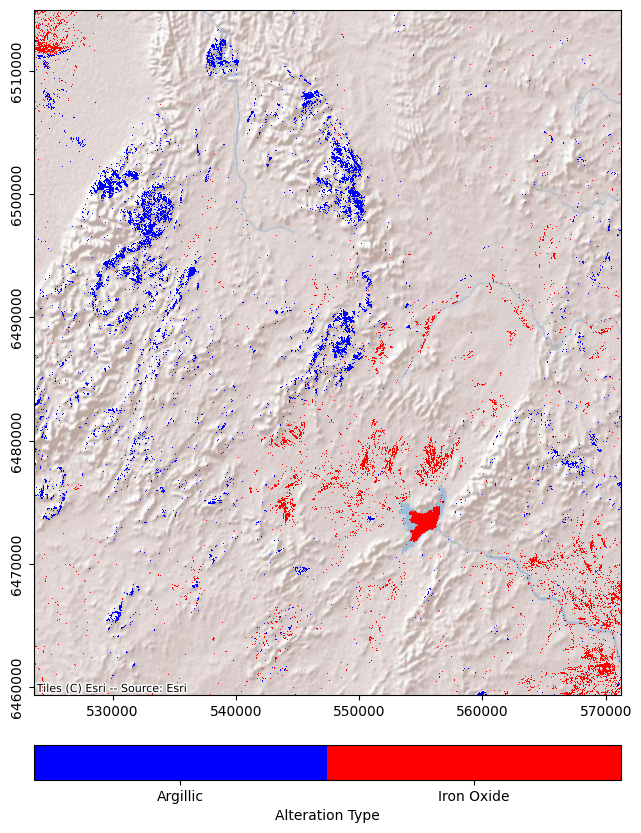

In [12]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_Landsat9.tif')
arrPred = arrPred.astype(float)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = best_model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

outFile = './Outputs/BrokenHill_Landsat9_PCA_MLP_AlterationMap.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')